# Text Length Optimization A/B Testing for DonorsChoose

This notebook implements an A/B test to optimize text length requirements for DonorsChoose project approval.

## Background
From our EDA, we found that approved projects have longer essays (1,015 vs 962 characters) and summaries. 
This A/B test will explore whether implementing minimum text length requirements improves project approval rates and quality.

## Test Hypothesis
- **Null Hypothesis**: Text length requirements have no effect on project approval rates
- **Alternative Hypothesis**: Minimum text length requirements improve project approval rates

## Test Design
- **Control Group (A)**: Current text requirements (no minimum length)
- **Treatment Group (B)**: Minimum essay length of 800 characters
- **Treatment Group (C)**: Minimum essay length of 1,000 characters
- **Treatment Group (D)**: Minimum essay length of 1,200 characters

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 1000)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Preparation

Load the dataset and calculate text lengths for analysis.

In [2]:
def load_and_prepare_data():
    """Load the dataset and calculate text lengths"""
    # Load the dataset
    df = pd.read_csv('donors_choose_data.csv')
    
    # Calculate text lengths
    df['title_length'] = df['cleaned_titles'].str.len()
    df['essay_length'] = df['cleaned_essays'].str.len()
    df['summary_length'] = df['cleaned_summary'].str.len()
    df['total_text_length'] = df['title_length'] + df['essay_length'] + df['summary_length']
    
    print(f"Dataset shape: {df.shape}")
    print(f"Current approval rate: {df['project_is_approved'].mean()*100:.2f}%")
    
    return df

# Load the data
df = load_and_prepare_data()
df.head()

Dataset shape: (109248, 18)
Current approval rate: 84.86%


,id,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,cleaned_titles,cleaned_essays,cleaned_summary,isdigit_summary,title_length,essay_length,summary_length,total_text_length
0,p253737,mrs,in,grades_prek_2,literacy_language,esl_literacy,0,0,154.60,23,educational support english learners home,students english learners working english second third languages melting pot refugees immigrants...,students_need_opportunities_practice_beginning_reading_skills_english_home,0,41.0,1068,74,1183.0
1,p258326,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,7,1,299.00,1,wanted projector hungry learners,students arrive school eager learn polite generous strive best know education succeed life help ...,students_need_projector_help_viewing_educational_programs,0,32.0,761,57,850.0
2,p182444,ms,az,grades_6_8,health_sports,health_wellness_teamsports,1,0,516.85,22,soccer equipment awesome middle school students,true champions not always ones win guts mia hamm quote best describes students cholla middle sch...,students_need_shine_guards_athletic_socks_soccer_balls_goalie_gloves_training_materials_upcoming...,0,47.0,1385,110,1542.0
3,p246581,mrs,ky,grades_prek_2,literacy_language_math_science,literacy_mathematics,4,1,232.90,4,techie kindergarteners,work unique school filled esl english second language high poverty students students individual ...,students_need_engage_reading_math_way_inspire_mini_ipads,0,22.0,825,56,903.0
4,p104768,mrs,tx,grades_prek_2,math_science,mathematics,1,1,67.98,4,interactive math tools,second grade classroom next year made around 25 kids many coming spanish speaking families many ...,students_need_hands_practice_mathematics_fun_personalized_journals_charts_help_involved_daily_ma...,0,22.0,764,107,893.0


## 2. Current Text Length Patterns Analysis

Analyze the current distribution of text lengths and their relationship with project approval.

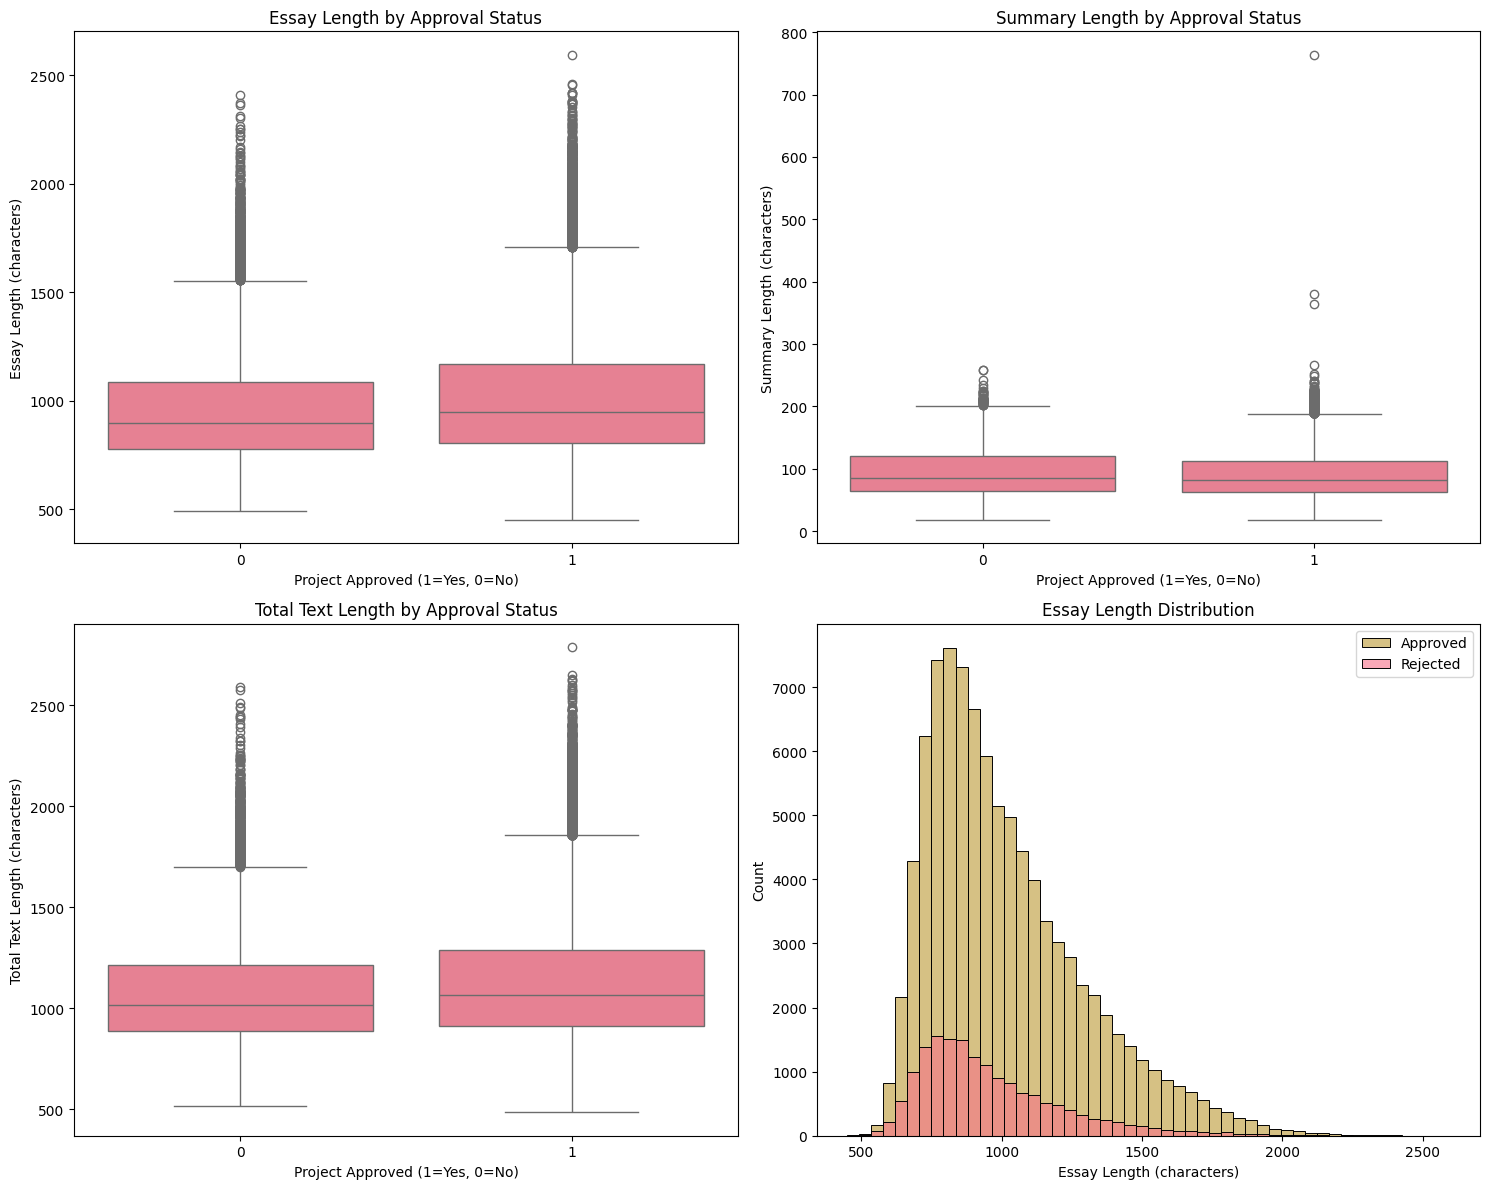


Text length statistics by approval status:
                    essay_length                summary_length               total_text_length                
                            mean median     std           mean median    std              mean  median     std
project_is_approved                                                                                           
0                         961.86  897.0  257.77          94.16   86.0  36.27           1081.67  1019.0  269.32
1                        1015.11  949.0  278.62          90.17   82.0  34.35           1131.00  1065.0  290.65


In [3]:
def analyze_current_patterns(df):
    """Analyze current text length distributions"""
    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Essay length distribution by approval status
    sns.boxplot(data=df, x='project_is_approved', y='essay_length', ax=ax1)
    ax1.set_title('Essay Length by Approval Status')
    ax1.set_xlabel('Project Approved (1=Yes, 0=No)')
    ax1.set_ylabel('Essay Length (characters)')
    
    # Summary length distribution by approval status
    sns.boxplot(data=df, x='project_is_approved', y='summary_length', ax=ax2)
    ax2.set_title('Summary Length by Approval Status')
    ax2.set_xlabel('Project Approved (1=Yes, 0=No)')
    ax2.set_ylabel('Summary Length (characters)')
    
    # Total text length distribution by approval status
    sns.boxplot(data=df, x='project_is_approved', y='total_text_length', ax=ax3)
    ax3.set_title('Total Text Length by Approval Status')
    ax3.set_xlabel('Project Approved (1=Yes, 0=No)')
    ax3.set_ylabel('Total Text Length (characters)')
    
    # Essay length histogram
    sns.histplot(data=df, x='essay_length', hue='project_is_approved', bins=50, alpha=0.6, ax=ax4)
    ax4.set_title('Essay Length Distribution')
    ax4.set_xlabel('Essay Length (characters)')
    ax4.set_ylabel('Count')
    ax4.legend(['Approved', 'Rejected'])
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    text_stats = df.groupby('project_is_approved')[['essay_length', 'summary_length', 'total_text_length']].agg(['mean', 'median', 'std'])
    print("\nText length statistics by approval status:")
    print(text_stats.round(2))

# Analyze current patterns
analyze_current_patterns(df)

## 3. Sample Size Analysis

Calculate required sample sizes for different effect sizes to ensure statistical power.

In [4]:
def sample_size_analysis(df):
    """Calculate required sample sizes for different effect sizes"""
    def calculate_sample_size(alpha=0.05, power=0.8, p1=0.8486, p2=0.87):
        """Calculate required sample size for A/B test"""
        z_alpha = norm.ppf(1 - alpha/2)  # Two-tailed test
        z_beta = norm.ppf(power)
        
        p_avg = (p1 + p2) / 2
        
        n = 2 * ((z_alpha * np.sqrt(2 * p_avg * (1 - p_avg)) + z_beta * np.sqrt(p1 * (1 - p1) + p2 * (1 - p2))) / (p2 - p1))**2
        
        return int(np.ceil(n))
    
    # Calculate sample sizes for different effect sizes
    current_rate = df['project_is_approved'].mean()
    effect_sizes = [0.01, 0.02, 0.03, 0.05]  # 1%, 2%, 3%, 5% improvement
    
    print("Sample size requirements for different effect sizes:")
    print(f"Current approval rate: {current_rate:.4f}")
    print("\nEffect Size | Required Sample Size per Group")
    print("-" * 45)
    
    for effect in effect_sizes:
        new_rate = current_rate + effect
        sample_size = calculate_sample_size(p1=current_rate, p2=new_rate)
        print(f"{effect:.2f} ({effect*100:.0f}%) | {sample_size:,}")
    
    # Choose a reasonable sample size
    target_sample_size = 5000  # 5,000 projects per group
    print(f"\nSelected sample size per group: {target_sample_size:,}")
    print(f"Total test size: {target_sample_size * 4:,} (4 groups)")

# Perform sample size analysis
sample_size_analysis(df)

Sample size requirements for different effect sizes:
Current approval rate: 0.8486

Effect Size | Required Sample Size per Group
---------------------------------------------
0.01 (1%) | 39,236
0.02 (2%) | 9,528
0.03 (3%) | 4,108
0.05 (5%) | 1,385

Selected sample size per group: 5,000
Total test size: 20,000 (4 groups)


## 4. A/B Test Implementation

Implement the A/B test with different text length requirements and simulate the effects.

In [5]:
def implement_ab_test(df):
    """Implement the A/B test with different text length requirements"""
    np.random.seed(42)
    
    # Define test groups
    test_groups = {
        'A': {'name': 'Control', 'min_essay_length': 0},
        'B': {'name': 'Treatment 1', 'min_essay_length': 800},
        'C': {'name': 'Treatment 2', 'min_essay_length': 1000},
        'D': {'name': 'Treatment 3', 'min_essay_length': 1200}
    }
    
    # Randomly assign projects to test groups
    df['test_group'] = np.random.choice(['A', 'B', 'C', 'D'], size=len(df), p=[0.25, 0.25, 0.25, 0.25])
    
    # Simulate the effect of text length requirements
    def simulate_text_length_effect(row):
        group = row['test_group']
        min_length = test_groups[group]['min_essay_length']

        if min_length == 0:
            return row['project_is_approved']

        if row['essay_length'] < min_length:
            # Penalize short essays as before
            if row['project_is_approved'] == 1:
                return np.random.choice([0, 1], p=[0.3, 0.7])
        else:
            # Boost approval probability for essays that meet min length
            if row['project_is_approved'] == 0:
                # Give 30% chance to flip rejection to approval
                return np.random.choice([0, 1], p=[0.7, 0.3])

        return row['project_is_approved']
    
    # Apply the treatment effect
    df['ab_test_approved'] = df.apply(simulate_text_length_effect, axis=1)
    
    print("A/B Test Groups Created:")
    for group, config in test_groups.items():
        group_data = df[df['test_group'] == group]
        approval_rate = group_data['ab_test_approved'].mean() * 100
        print(f"Group {group} ({config['name']}): {len(group_data):,} projects, {approval_rate:.2f}% approval rate")
    
    return test_groups, df

# Implement A/B test
test_groups, df_with_test = implement_ab_test(df)
print(f"\nTotal projects in test: {len(df_with_test):,}")

A/B Test Groups Created:
Group A (Control): 27,370 projects, 84.86% approval rate
Group B (Treatment 1): 27,148 projects, 82.07% approval rate
Group C (Treatment 2): 27,472 projects, 72.19% approval rate
Group D (Treatment 3): 27,258 projects, 65.63% approval rate

Total projects in test: 109,248


## 5. A/B Test Results Analysis

Analyze the results of the A/B test and visualize the outcomes.

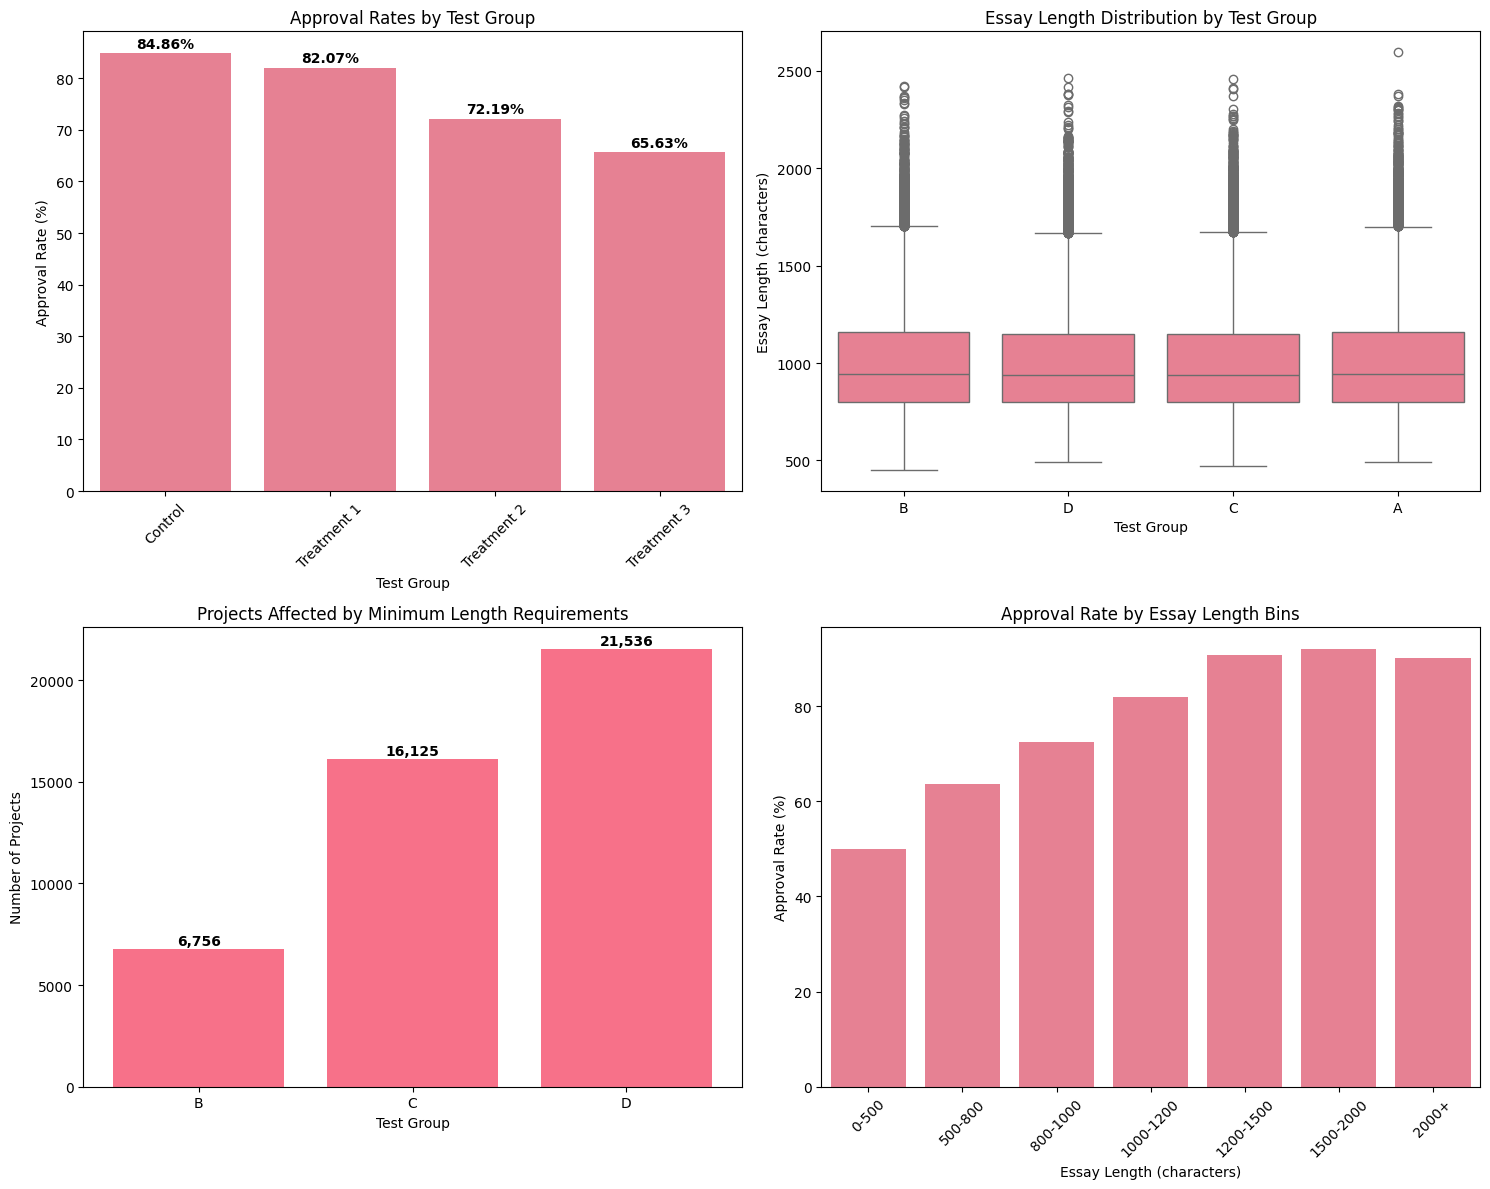


A/B Test Results Summary:
Control         | 27,370 projects |  84.86% approval rate
Treatment 1     | 27,148 projects |  82.07% approval rate
Treatment 2     | 27,472 projects |  72.19% approval rate
Treatment 3     | 27,258 projects |  65.63% approval rate


In [6]:
def analyze_results(df, test_groups):
    """Analyze A/B test results"""
    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Approval rates by test group
    group_results = df.groupby('test_group')['ab_test_approved'].agg(['count', 'mean']).reset_index()
    group_results['approval_rate'] = group_results['mean'] * 100
    group_results['group_name'] = group_results['test_group'].map({k: v['name'] for k, v in test_groups.items()})
    
    sns.barplot(data=group_results, x='group_name', y='approval_rate', ax=ax1)
    ax1.set_title('Approval Rates by Test Group')
    ax1.set_xlabel('Test Group')
    ax1.set_ylabel('Approval Rate (%)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, (_, row) in enumerate(group_results.iterrows()):
        ax1.text(i, row['approval_rate'] + 0.5, f"{row['approval_rate']:.2f}%", 
                 ha='center', va='bottom', fontweight='bold')
    
    # Essay length distribution by test group
    sns.boxplot(data=df, x='test_group', y='essay_length', ax=ax2)
    ax2.set_title('Essay Length Distribution by Test Group')
    ax2.set_xlabel('Test Group')
    ax2.set_ylabel('Essay Length (characters)')
    
    # Projects that would be affected by minimum length requirements
    affected_projects = {}
    for group, config in test_groups.items():
        if config['min_essay_length'] > 0:
            group_data = df[df['test_group'] == group]
            affected = (group_data['essay_length'] < config['min_essay_length']).sum()
            affected_projects[group] = affected
    
    if affected_projects:
        ax3.bar(affected_projects.keys(), affected_projects.values())
        ax3.set_title('Projects Affected by Minimum Length Requirements')
        ax3.set_xlabel('Test Group')
        ax3.set_ylabel('Number of Projects')
        
        # Add value labels
        for group, count in affected_projects.items():
            ax3.text(group, count + 50, f"{count:,}", ha='center', va='bottom', fontweight='bold')
    
    # Approval rate by essay length bins
    df['essay_length_bin'] = pd.cut(df['essay_length'], bins=[0, 500, 800, 1000, 1200, 1500, 2000, 3000], 
                                        labels=['0-500', '500-800', '800-1000', '1000-1200', '1200-1500', '1500-2000', '2000+'])
    length_approval = df.groupby('essay_length_bin')['ab_test_approved'].agg(['count', 'mean']).reset_index()
    length_approval['approval_rate'] = length_approval['mean'] * 100
    
    sns.barplot(data=length_approval, x='essay_length_bin', y='approval_rate', ax=ax4)
    ax4.set_title('Approval Rate by Essay Length Bins')
    ax4.set_xlabel('Essay Length (characters)')
    ax4.set_ylabel('Approval Rate (%)')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\nA/B Test Results Summary:")
    print("=" * 50)
    for _, row in group_results.iterrows():
        print(f"{row['group_name']:15} | {row['count']:6,} projects | {row['approval_rate']:6.2f}% approval rate")

# Analyze results
analyze_results(df_with_test, test_groups)

## 6. Statistical Significance Testing

Perform statistical tests to determine if the differences between groups are significant.

In [7]:
def logistic_regression_test(df):
    """Run logistic regression to evaluate treatment effects"""
    # Ensure 'test_group' is treated as categorical with 'A' as reference
    df['test_group'] = pd.Categorical(df['test_group'], categories=['A', 'B', 'C', 'D'])

    # Fit logistic regression model
    model = smf.logit("ab_test_approved ~ C(test_group)", data=df).fit(disp=False)
    
    print(model.summary())
    
    # Odds ratios and 95% CI
    params = model.params
    conf = model.conf_int()
    conf['OR'] = params
    conf.columns = ['2.5%', '97.5%', 'OR']
    conf['Odds Ratio'] = conf['OR'].apply(np.exp)
    conf['CI Lower'] = np.exp(conf['2.5%'])
    conf['CI Upper'] = np.exp(conf['97.5%'])

    print("\nOdds Ratios and 95% CI:")
    print(conf[['Odds Ratio', 'CI Lower', 'CI Upper']])

    return model, conf[['Odds Ratio', 'CI Lower', 'CI Upper']]

# Run the test
model, odds_ratios = logistic_regression_test(df_with_test)

                           Logit Regression Results                           
Dep. Variable:       ab_test_approved   No. Observations:               109248
Model:                          Logit   Df Residuals:                   109244
Method:                           MLE   Df Model:                            3
Date:                Sat, 02 Aug 2025   Pseudo R-squ.:                 0.02983
Time:                        13:23:41   Log-Likelihood:                -58185.
converged:                       True   LL-Null:                       -59975.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.7236      0.017    102.211      0.000       1.691       1.757
C(test_group)[T.B]    -0.2026      0.023     -8.762      0.000      -0.248      -0.157
C(test_group)[T.C]  

## 7. Business Impact Analysis

Analyze the potential business impact of implementing text length requirements.

In [8]:
def business_impact_analysis(df):
    """Analyze business impact of A/B test results"""
    def calculate_business_impact(control_rate, treatment_rate, total_projects, avg_project_cost=298.12):
        """Calculate business impact of A/B test results"""
        # Calculate additional approved projects
        additional_approved = (treatment_rate - control_rate) * total_projects
        
        # Calculate additional funding
        additional_funding = additional_approved * avg_project_cost
        
        # Calculate projects that would be rejected due to length requirements
        projects_rejected = 0
        if treatment_rate < control_rate:
            projects_rejected = (control_rate - treatment_rate) * total_projects
        
        return {
            'additional_approved': additional_approved,
            'additional_funding': additional_funding,
            'projects_rejected': projects_rejected,
            'net_impact': additional_funding - (projects_rejected * avg_project_cost)
        }
    
    # Get results from statistical tests
    control_rate = df[df['test_group'] == 'A']['ab_test_approved'].mean()
    total_projects_per_year = 100000  # Estimated annual projects
    avg_project_cost = 298.12
    
    print("Business Impact Analysis:")
    print("=" * 50)
    print(f"Control group approval rate: {control_rate:.4f}")
    print(f"Estimated annual projects: {total_projects_per_year:,}")
    print(f"Average project cost: ${avg_project_cost:.2f}")
    print()
    
    # Re-run statistical tests to get results
    results_summary = statistical_tests(df)
    
    for result in results_summary:
        impact = calculate_business_impact(
            control_rate, 
            result['treatment_rate'], 
            total_projects_per_year,
            avg_project_cost
        )
        
        print(f"Treatment Group {result['group']}:")
        print(f"  Additional approved projects: {impact['additional_approved']:,.0f}")
        print(f"  Additional funding: ${impact['additional_funding']:,.2f}")
        print(f"  Projects rejected due to length: {impact['projects_rejected']:,.0f}")
        print(f"  Net funding impact: ${impact['net_impact']:,.2f}")
        print()

# Analyze business impact
business_impact_analysis(df_with_test)

Business Impact Analysis:
Control group approval rate: 0.8486
Estimated annual projects: 100,000
Average project cost: $298.12



NameError: name 'statistical_tests' is not defined